In [7]:
# test_masked_prediction_notebook.py
# Notebook-friendly version - displays plots inline

import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

# Add path to your modules if needed
sys.path.append('/mnt/user-data/uploads')
from jaisp_dataset_v4 import JAISPDatasetV4, ALL_BANDS
from jaisp_foundation_v4 import JAISPFoundationV4

def mask_region(img, mask_size=64, mask_value=0.0):
    """Mask out a square region in the center."""
    img_masked = img.clone()
    h, w = img.shape[-2:]
    y_start = (h - mask_size) // 2
    x_start = (w - mask_size) // 2
    img_masked[..., y_start:y_start+mask_size, x_start:x_start+mask_size] = mask_value
    return img_masked, (y_start, x_start, mask_size)

def predict_from_cross_view(model, view1_img, view1_rms, view1_band, 
                            view2_img, view2_rms, view2_band, device):
    """
    Use view2 (e.g., Euclid) to predict what view1 (e.g., Rubin) should look like.
    Returns the token embeddings from both views.
    """
    with torch.no_grad():
        # Add batch dimension if needed
        if view1_img.dim() == 3:
            view1_img = view1_img.unsqueeze(0)
            view1_rms = view1_rms.unsqueeze(0)
        if view2_img.dim() == 3:
            view2_img = view2_img.unsqueeze(0)
            view2_rms = view2_rms.unsqueeze(0)
            
        result1 = model.encode(
            view1_img.to(device), 
            view1_rms.to(device), 
            view1_band
        )
        result2 = model.encode(
            view2_img.to(device), 
            view2_rms.to(device), 
            view2_band
        )
    
    return result1['z'], result2['z'], result1['grid_size'], result2['grid_size']

def test_masked_prediction(
    model_path: str,
    rubin_dir: str,
    euclid_dir: str,
    n_samples: int = 5,
    mask_size: int = 64,
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    print(f"Loading model from {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model with correct parameters
    model = JAISPFoundationV4(
        band_names=ALL_BANDS,
        stem_ch=64,
        embed_dim=256,
        proj_dim=256,
        depth=6,
        patch_size=16,
        shift_px=2,
        shift_temp=0.07,
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model'])
    model.eval()
    
    print(f"✓ Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"✓ Model loss: {checkpoint.get('loss', 'unknown'):.4f}\n")
    
    # Load dataset
    dataset = JAISPDatasetV4(
        rubin_dir=rubin_dir,
        euclid_dir=euclid_dir,
        augment=False,
        cross_prob=1.0,  # Force cross-instrument pairs
    )
    
    results = []
    
    print(f"Testing masked prediction on {n_samples} samples...\n")
    for i in range(min(n_samples, len(dataset))):
        sample = dataset[i]
        
        # Get a Rubin-Euclid pair
        if not sample['is_cross_pair']:
            print(f"Sample {i}: skipping (not cross-pair)")
            continue
            
        view1_img = sample['view1_image']
        view1_rms = sample['view1_rms']
        view1_band = sample['view1_band']
        
        view2_img = sample['view2_image']
        view2_rms = sample['view2_rms']
        view2_band = sample['view2_band']
        
        print(f"Sample {i}: {view1_band} ({view1_img.shape[1:]}) ↔ {view2_band} ({view2_img.shape[1:]})")
        
        # Mask view1
        view1_masked, (y, x, size) = mask_region(view1_img, mask_size)
        
        # Get embeddings - full view1
        z1_full, z2, gs1_full, gs2 = predict_from_cross_view(
            model, view1_img, view1_rms, view1_band,
            view2_img, view2_rms, view2_band, device
        )
        
        # Get embeddings - masked view1
        z1_masked, _, gs1_masked, _ = predict_from_cross_view(
            model, view1_masked, view1_rms, view1_band,
            view2_img, view2_rms, view2_band, device
        )
        
        # Extract masked region tokens
        H1, W1 = view1_img.shape[-2:]
        token_grid_h, token_grid_w = gs1_full
        
        token_y_start = int(y / H1 * token_grid_h)
        token_x_start = int(x / W1 * token_grid_w)
        token_y_end = int((y + size) / H1 * token_grid_h)
        token_x_end = int((x + size) / W1 * token_grid_w)
        
        # Reshape to spatial grid
        B, N, D = z1_full.shape
        z1_full_grid = z1_full.reshape(B, token_grid_h, token_grid_w, D)
        z1_masked_grid = z1_masked.reshape(B, token_grid_h, token_grid_w, D)
        z2_grid = z2.reshape(B, gs2[0], gs2[1], D)
        
        # Extract masked region
        z1_full_region = z1_full_grid[0, token_y_start:token_y_end, token_x_start:token_x_end]
        z1_masked_region = z1_masked_grid[0, token_y_start:token_y_end, token_x_start:token_x_end]
        
        # For z2, map to corresponding region
        token2_y_start = int(token_y_start / token_grid_h * gs2[0])
        token2_x_start = int(token_x_start / token_grid_w * gs2[1])
        token2_y_end = int(token_y_end / token_grid_h * gs2[0])
        token2_x_end = int(token_x_end / token_grid_w * gs2[1])
        z2_region = z2_grid[0, token2_y_start:token2_y_end, token2_x_start:token2_x_end]
        
        # Flatten and compute similarities
        z1_full_flat = z1_full_region.flatten()
        z1_masked_flat = z1_masked_region.flatten()
        z2_flat = z2_region.flatten()
        
        # Cosine similarity (full vs masked - same size)
        cos_full_vs_masked = torch.cosine_similarity(
            z1_full_flat.unsqueeze(0), 
            z1_masked_flat.unsqueeze(0), 
            dim=1
        ).item()
        
        # For cross-view, handle size mismatch by using global pooled embeddings
        if z1_full_flat.shape[0] != z2_flat.shape[0]:
            # Pool each region to a single vector (mean over spatial tokens)
            z1_pooled = z1_full_region.mean(dim=(0, 1))  # [D]
            z2_pooled = z2_region.mean(dim=(0, 1))  # [D]
            cos_full_vs_cross = torch.cosine_similarity(
                z1_pooled.unsqueeze(0), 
                z2_pooled.unsqueeze(0), 
                dim=1
            ).item()
        else:
            cos_full_vs_cross = torch.cosine_similarity(
                z1_full_flat.unsqueeze(0), 
                z2_flat.unsqueeze(0), 
                dim=1
            ).item()
        
        results.append({
            'sample_idx': i,
            'view1_band': view1_band,
            'view2_band': view2_band,
            'cos_full_vs_masked': cos_full_vs_masked,
            'cos_full_vs_cross': cos_full_vs_cross,
            'images': {
                'view1_original': view1_img.squeeze().cpu().numpy(),
                'view1_masked': view1_masked.squeeze().cpu().numpy(),
                'view2': view2_img.squeeze().cpu().numpy(),
            },
            'mask_region': (y, x, size),
        })
        
        print(f"  → Full vs Masked similarity: {cos_full_vs_masked:.3f}")
        print(f"  → Full vs Cross-view similarity: {cos_full_vs_cross:.3f}\n")
    
    # Visualize
    if len(results) == 0:
        print("❌ No cross-pairs found!")
        return results
    
    # Create figure
    fig, axes = plt.subplots(len(results), 3, figsize=(14, 4*len(results)))
    if len(results) == 1:
        axes = axes[np.newaxis, :]
    
    for idx, result in enumerate(results):
        y, x, size = result['mask_region']
        
        # Original
        img_orig = result['images']['view1_original']
        v1, v99 = np.percentile(img_orig, [1, 99])
        axes[idx, 0].imshow(img_orig, cmap='gray', vmin=v1, vmax=v99)
        rect = plt.Rectangle((x, y), size, size, fill=False, edgecolor='red', linewidth=2)
        axes[idx, 0].add_patch(rect)
        axes[idx, 0].set_title(f"{result['view1_band']} (original)\nfull vs masked: {result['cos_full_vs_masked']:.3f}", fontsize=10)
        axes[idx, 0].axis('off')
        
        # Masked
        img_masked = result['images']['view1_masked']
        axes[idx, 1].imshow(img_masked, cmap='gray', vmin=v1, vmax=v99)
        axes[idx, 1].set_title(f"{result['view1_band']} (masked 64×64)", fontsize=10)
        axes[idx, 1].axis('off')
        
        # Cross-view
        img_cross = result['images']['view2']
        v1c, v99c = np.percentile(img_cross, [1, 99])
        axes[idx, 2].imshow(img_cross, cmap='gray', vmin=v1c, vmax=v99c)
        axes[idx, 2].set_title(f"{result['view2_band']} (reference)\nfull vs cross: {result['cos_full_vs_cross']:.3f}", fontsize=10)
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    avg_full_masked = np.mean([r['cos_full_vs_masked'] for r in results])
    avg_full_cross = np.mean([r['cos_full_vs_cross'] for r in results])
    
    print(f"\nAverage similarity (full vs masked):     {avg_full_masked:.3f}")
    print(f"Average similarity (full vs cross-view):  {avg_full_cross:.3f}")
    
    print(f"\n📊 Interpretation:")
    if avg_full_masked > 0.9:
        print(f"  ⚠️  Full/Masked similarity is HIGH ({avg_full_masked:.3f}) - masking barely changed representation")
    elif avg_full_masked < 0.7:
        print(f"  ✓  Full/Masked similarity is LOW ({avg_full_masked:.3f}) - masked region matters to model")
    else:
        print(f"  ~  Full/Masked similarity is MODERATE ({avg_full_masked:.3f})")
    
    if avg_full_cross > 0.8:
        print(f"  ✓  Full/Cross similarity is HIGH ({avg_full_cross:.3f}) - cross-view captures masked region info")
    elif avg_full_cross < 0.5:
        print(f"  ⚠️  Full/Cross similarity is LOW ({avg_full_cross:.3f}) - cross-view doesn't help predict")
    else:
        print(f"  ~  Full/Cross similarity is MODERATE ({avg_full_cross:.3f})")
    
    print("="*70)
    
    return results

Loading model from checkpoints/jaisp_v4/best.pt
✓ Loaded model from epoch 18
✓ Model loss: 0.0157

JAISPDatasetV4: 144 tiles (native resolutions)
  pairing: cross_prob=1.0, balance_usage=True, precompute_available=True
Testing masked prediction on 5 samples...

Sample 0: rubin_z (torch.Size([512, 512])) ↔ euclid_J (torch.Size([1050, 1050]))
  → Full vs Masked similarity: 0.103
  → Full vs Cross-view similarity: 0.958

Sample 1: rubin_y (torch.Size([512, 512])) ↔ euclid_VIS (torch.Size([1050, 1050]))
  → Full vs Masked similarity: 0.156
  → Full vs Cross-view similarity: 0.922

Sample 2: rubin_r (torch.Size([512, 512])) ↔ euclid_Y (torch.Size([1050, 1050]))
  → Full vs Masked similarity: 0.185
  → Full vs Cross-view similarity: 0.889

Sample 3: rubin_u (torch.Size([512, 512])) ↔ euclid_H (torch.Size([1050, 1050]))
  → Full vs Masked similarity: 0.274
  → Full vs Cross-view similarity: 0.898

Sample 4: rubin_i (torch.Size([512, 512])) ↔ euclid_J (torch.Size([1050, 1050]))
  → Full vs Mas

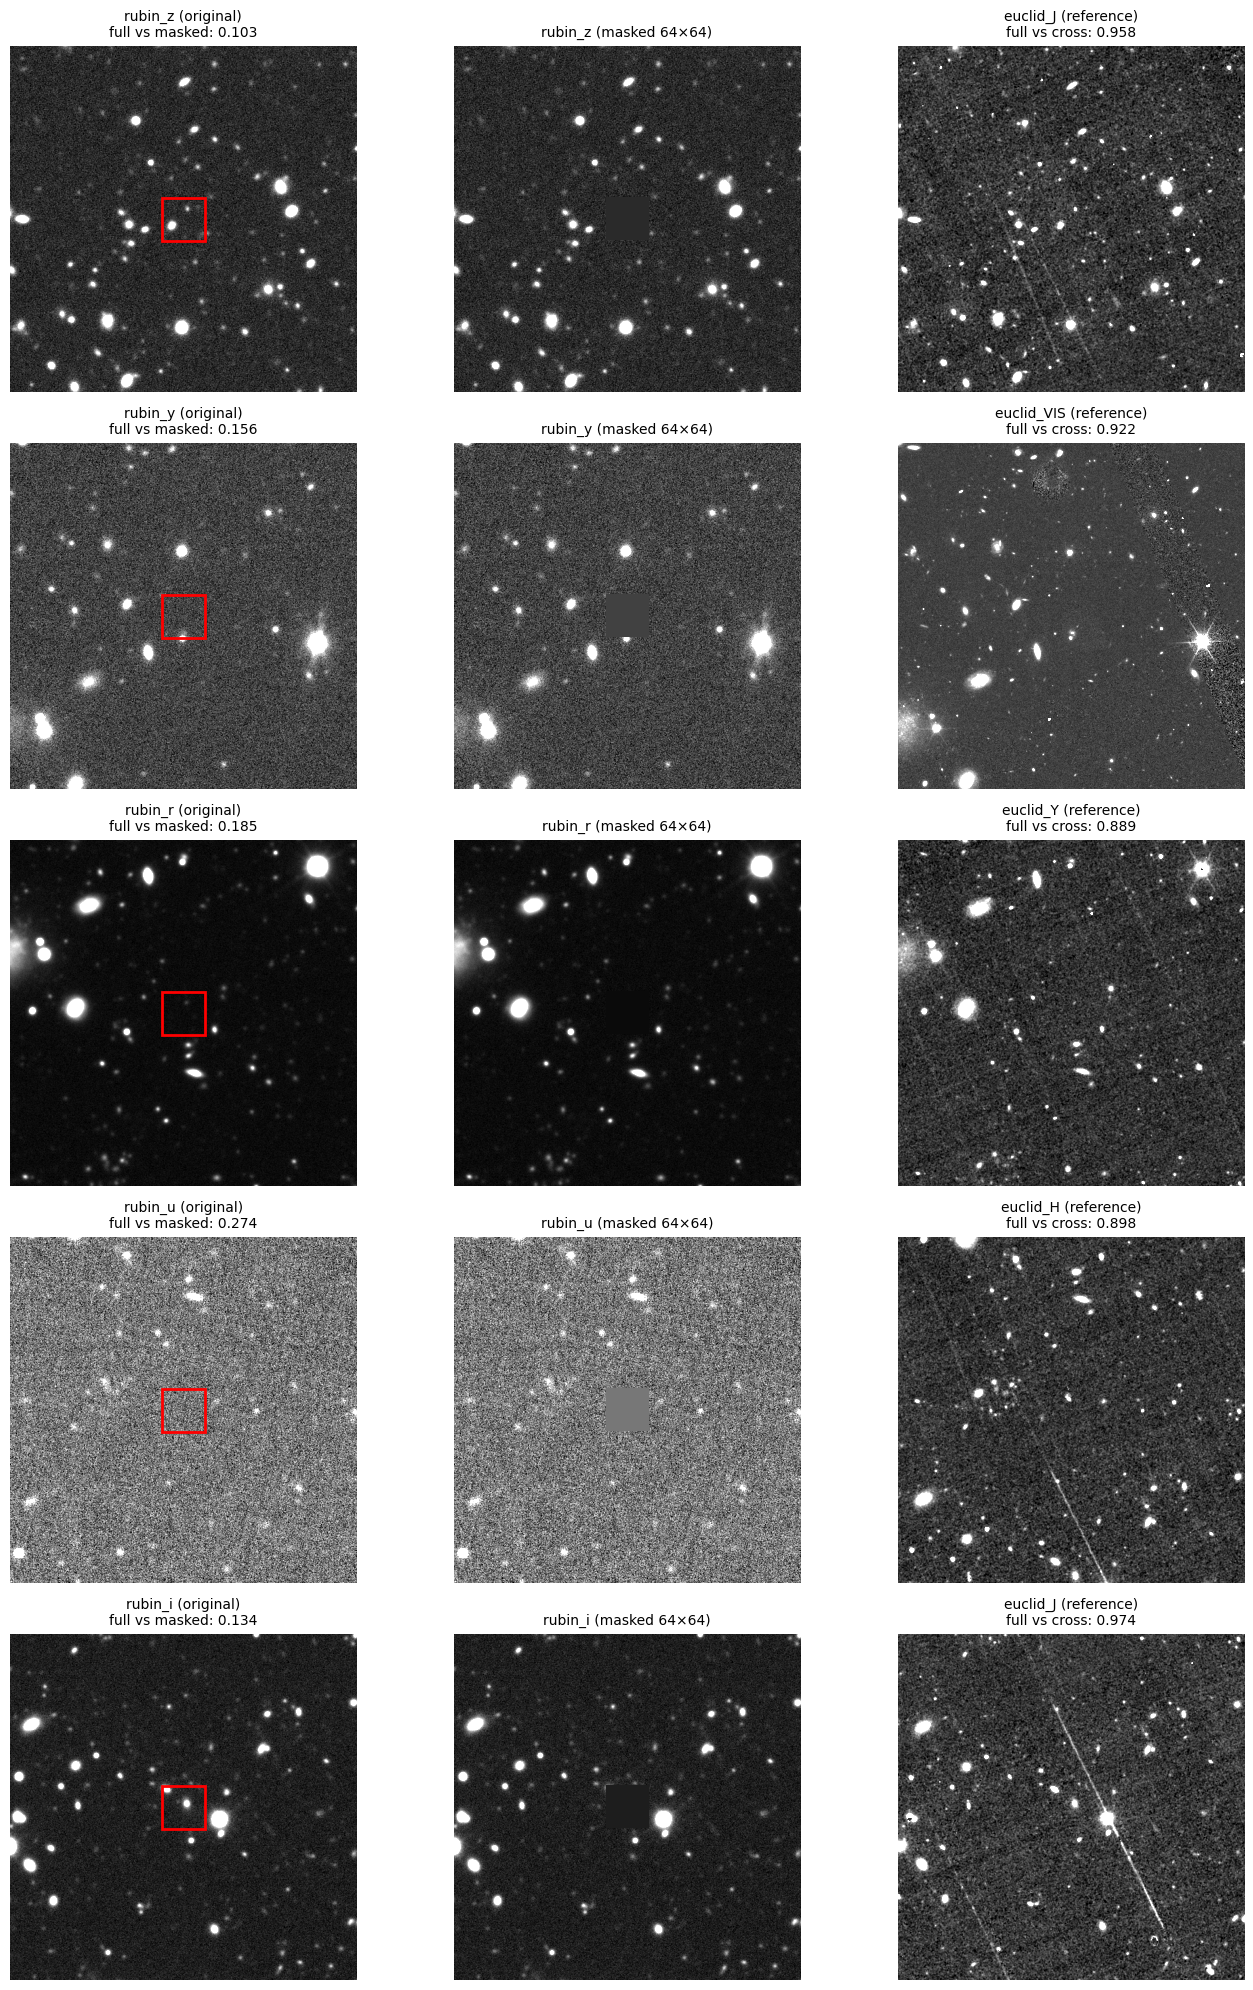


SUMMARY

Average similarity (full vs masked):     0.170
Average similarity (full vs cross-view):  0.928

📊 Interpretation:
  ✓  Full/Masked similarity is LOW (0.170) - masked region matters to model
  ✓  Full/Cross similarity is HIGH (0.928) - cross-view captures masked region info


In [8]:
results = test_masked_prediction(
    model_path='checkpoints/jaisp_v4/best.pt',
    rubin_dir='../data/rubin_tiles_ecdfs/',
    euclid_dir='../data/euclid_tiles_ecdfs/',
    n_samples=5,
    mask_size=64,
)